# Assignment 4 - SMAI - CNN and AutoEncoders

In [1]:
import os
import sys

# enter the Foldername here:
FOLDERNAME = "/home/richard/play/IIITH/sem5/smai/assignments/assignment-3-fine-man"

if FOLDERNAME is None or not os.path.exists(FOLDERNAME):
    FOLDERNAME = os.getcwd()

PATHNAME = f"{FOLDERNAME}"
sys.path.append(f"{FOLDERNAME}")

# DATA_FOLDER = os.path.join(FOLDERNAME, "SMAI-Dataset-release/IIIT-CFW")
DATA_FOLDER = os.path.join(FOLDERNAME, "datasets")
YAML_FOLDER = os.path.join(FOLDERNAME, "yaml-files")
print(DATA_FOLDER)
print(YAML_FOLDER)

/home/richard/play/IIITH/sem5/smai/assignments/assignment-3-fine-man/datasets
/home/richard/play/IIITH/sem5/smai/assignments/assignment-3-fine-man/yaml-files


In [2]:
# some magic so that the notebook will reload external python modules;
# see https://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
import copy
import os
from random import randrange
from matplotlib import pyplot as plt
from PIL import Image
import wandb

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset, Subset
from torch.utils.data import random_split

import torchvision
from torchvision import transforms

In [4]:
from src_torch import *
from src_torch.utils import train, evaluate
from src_torch.classifiers import *

## (4.1) - Data Visualization and Preprocessing

### (4.1.0) - Data Loading

In [5]:
transform = transforms.Compose([
    transforms.ToTensor()
])

# loading the MNIST data
mnist_train = torchvision.datasets.MNIST(
    root=DATA_FOLDER, train=True,
    transform=transform, download=True
)

mnist_test = torchvision.datasets.MNIST(
    root=DATA_FOLDER, train=False,
    transform=transform, download=True
)

print(f"Length of Train data: {len(mnist_train)}")
print(f"Length of Test data: {len(mnist_test)}")

Length of Train data: 60000
Length of Test data: 10000


### (4.1.1) - Showing distribution of classes

In [ ]:
labels = []
for data, label in mnist_dataset:
    labels.append(label)

labels = np.array(labels)

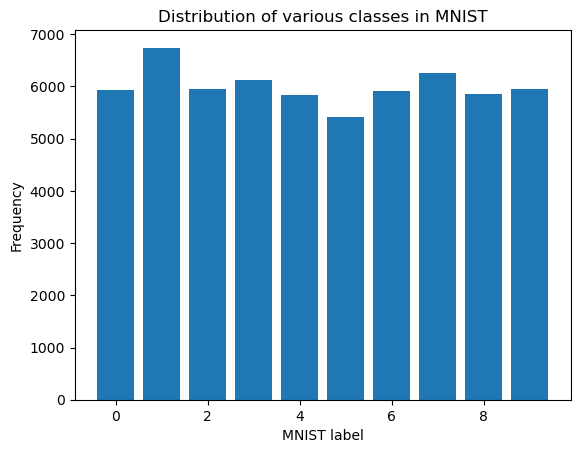

In [ ]:
fig, ax = plt.subplots(1, 1)

unique_labels, label_freq = np.unique(labels, return_counts=True)

ax.bar(unique_labels, label_freq)
ax.set_title("Distribution of various classes in MNIST")
ax.set_xlabel("MNIST label")
ax.set_ylabel("Frequency")

plt.show()

### (4.1.2) Visualizing samples from MNIST dataset

In [ ]:
features = mnist_dataset.data.view(-1, 28, 28)
labels = mnist_dataset.targets
print(features.shape)
print(labels.shape)

torch.Size([60000, 28, 28])
torch.Size([60000])


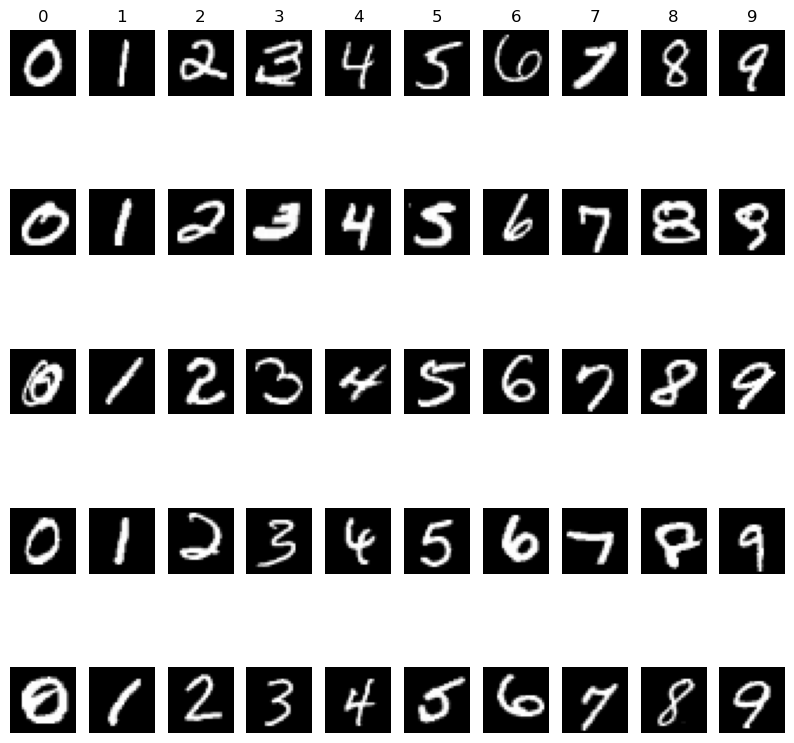

In [ ]:
examples_per_class = 5
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
plt.figure(figsize=(10, 10))
for cls_idx, cls_name in enumerate(classes):
    idxs = np.where(labels == cls_idx)[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls_idx + 1)
        plt.imshow(features[idx], cmap='gray')
        plt.axis("off")
        if i == 0:
            plt.title(f"{cls_name}")

plt.show()

### (4.1.4) Splitting data into train/val splits

In [6]:
val_ratio = 0.3
val_size = int(val_ratio * len(mnist_train))
train_size = len(mnist_train) - val_size

train_dataset, val_dataset = random_split(mnist_train, [train_size, val_size])

print(f"Length of Training Data: {len(train_dataset)}")
print(f"Length of Validation Data: {len(val_dataset)}")
print(f"Length of Testing Data: {len(mnist_test)}")

Length of Training Data: 42000
Length of Validation Data: 18000
Length of Testing Data: 10000


## (4.2) Model Building

### (4.2.3) Baseline CNN model

In [24]:
untrained_model = SimpleCNN()
print(untrained_model)

SimpleCNN(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)


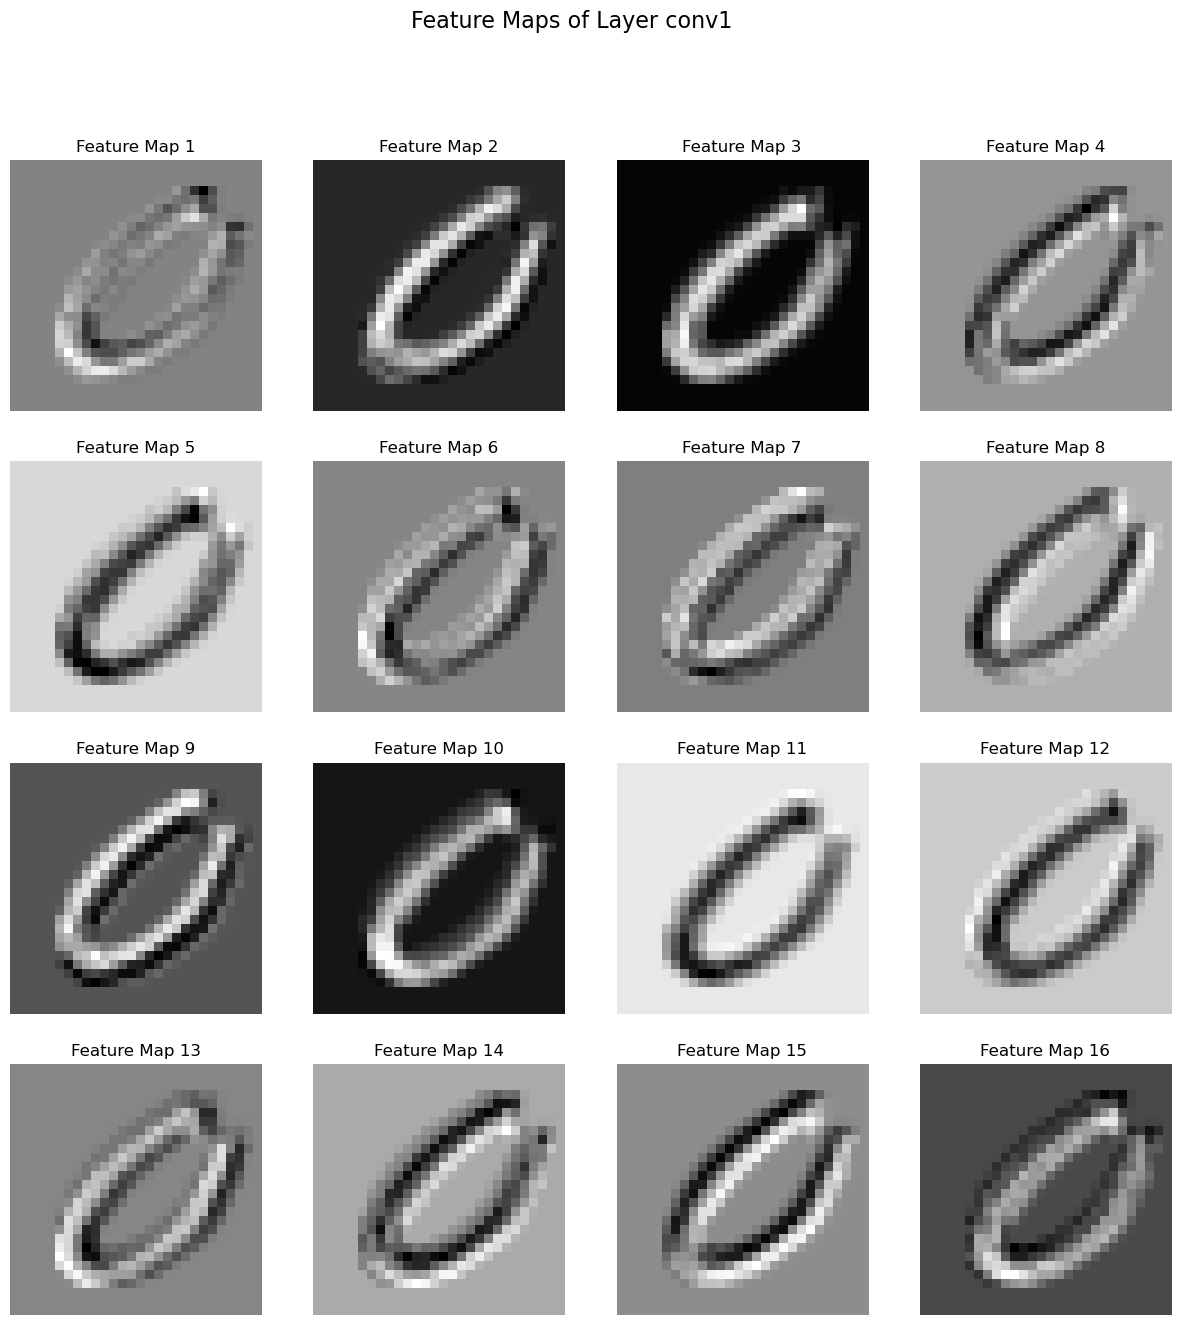

In [29]:
# Feature Maps before training
image, label = train_dataset[0]

visualize_feature_maps(untrained_model, image, 'conv1')

In [20]:
# Setup model, criterion and optimizer
model = SimpleCNN(num_classes=10)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(model, criterion, optimizer, train_dataset, val_dataset, print_every=10000)

Epoch: 1 | Train Accuracy: 96.162 | Val Accuracy: 96.228|  Train loss: 0.1282 | Val loss: 0.1290

Epoch: 2 | Train Accuracy: 97.907 | Val Accuracy: 97.644|  Train loss: 0.0754 | Val loss: 0.0810

Epoch: 3 | Train Accuracy: 98.290 | Val Accuracy: 97.850|  Train loss: 0.0585 | Val loss: 0.0685

Epoch: 4 | Train Accuracy: 98.476 | Val Accuracy: 98.156|  Train loss: 0.0498 | Val loss: 0.0606

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/richard/anaconda3/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_1051640/1270205534.py", line 6, in <module>
    train(model, criterion, optimizer, train_dataset, val_dataset, print_every=10000)
  File "/home/richard/play/IIITH/sem5/smai/assignments/assignment-3-fine-man/src_torch/utils.py", line 82, in train
    logits = model(X_minibatch)
  File "/home/richard/.local/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/richard/play/IIITH/sem5/smai/assignments/assignment-3-fine-man/src_torch/classifiers/mnist_cnn.py", line 28, in forward
    x = self.maxpool1(x)
  File "/home/richard/.local/lib/python3.10/site-packages/torch/nn/modules/module.py", line 1501, in _call_impl
    return forward_call(*args, **kwargs)
  File "/home/richard/.loc

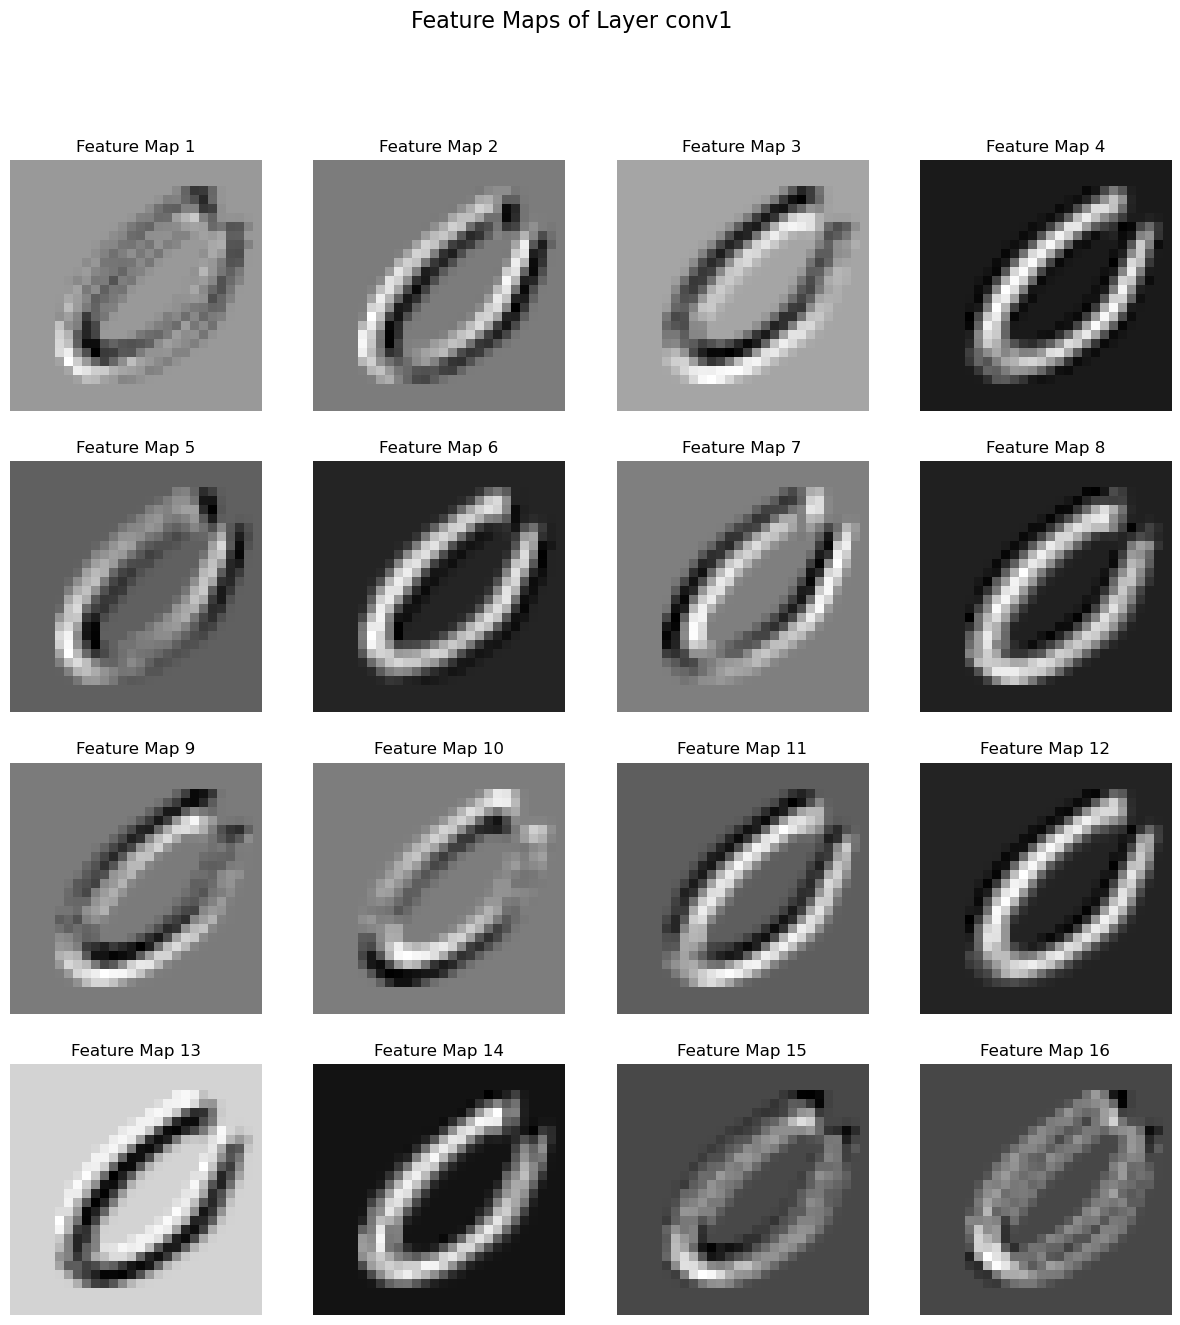

In [27]:
# Feature Maps before training
image, label = train_dataset[0]

visualize_feature_maps(model, image, 'conv1')